In [1172]:

import pandas as pd
import seaborn as sns 
import numpy as np 
import datetime
import os 
from matplotlib import pyplot as plt
import random
from sklearn import preprocessing


In [1173]:

from google.colab import drive
drive.mount('/content/drive')
# read csv from google drive 
sample_df = pd.read_csv('/content/drive/My Drive/final_sample_item364606.csv',parse_dates=['date']) 
sample_df = sample_df.drop(columns = ['Unnamed: 0'])
sample_df.set_index('date',inplace = True)
sample_df = sample_df[['unit_sales','onpromotion','transactions','oil_price','perishable','holiday']]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1174]:
# selecting columns and grouping by day for the years of interested 

sample_df = sample_df[['unit_sales','onpromotion','transactions','oil_price','perishable','holiday']]
sample_df = sample_df.resample('D').sum()
sample_df['dofweek'] = sample_df.index.dayofweek
sample_df['day'] = sample_df.index.day
sample_df['month'] = sample_df.index.month

sample_df = sample_df[sample_df.index.year <= 2014]


In [1175]:
# split test and train 
train_size = int(len(sample_df)*0.8)
test_size = len(sample_df) - train_size
train, test = sample_df.iloc[0:train_size], sample_df.iloc[train_size:len(sample_df)]
print(len(train), len(test))

584 146


In [1176]:
# scale data in f_columns 
from sklearn.preprocessing import MinMaxScaler

# select columns to scale 
f_columns = ['onpromotion',	'transactions',	'oil_price',	'perishable',	'holiday',	'dofweek',	'day',	'month']

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()

# scale for the y and x variables 

scaler = scaler.fit(train[f_columns].to_numpy())
scaler2 = scaler2.fit(train[['unit_sales']])

train.loc[:, f_columns] = scaler.transform(train[f_columns].to_numpy())
train['unit_sales'] = scaler2.transform(train[['unit_sales']])

test.loc[:, f_columns] = scaler.transform(test[f_columns].to_numpy())
test['unit_sales'] = scaler2.transform(test[['unit_sales']])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [1177]:
# method that makes the data into sequential format [samples, lag, n_features]
def create_dataset(X, y, lag=1):
    Xs, ys = [], []
    for i in range(len(X) - lag):
        v = X.iloc[i:(i + lag)].values
        Xs.append(v)        
        ys.append(y.iloc[i + lag])
    return np.array(Xs), np.array(ys)

In [1178]:
# lag present in the model 
lag = 1

train_x, train_y = create_dataset(train, train.unit_sales, lag)
test_x, test_y = create_dataset(test, test.unit_sales, lag)
print(train_x.shape, train_y.shape)

(583, 1, 9) (583,)


In [1179]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow import keras
import math 
from sklearn.metrics import mean_squared_error


In [1180]:
# sequential model with 3 layers 
# biderectional lstm 

model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=256, 
      input_shape=(train_x.shape[1], train_x.shape[2]),
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
opt= keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=opt)


Epoch 1/45
10/10 [==============================] - 6s 120ms/step - loss: 0.0845 - val_loss: 0.0605
Epoch 2/45
10/10 [==============================] - 0s 16ms/step - loss: 0.0400 - val_loss: 0.0268
Epoch 3/45
10/10 [==============================] - 0s 16ms/step - loss: 0.0238 - val_loss: 0.0213
Epoch 4/45
10/10 [==============================] - 0s 17ms/step - loss: 0.0142 - val_loss: 0.0321
Epoch 5/45
10/10 [==============================] - 0s 17ms/step - loss: 0.0172 - val_loss: 0.0270
Epoch 6/45
10/10 [==============================] - 0s 19ms/step - loss: 0.0126 - val_loss: 0.0289
Epoch 7/45
10/10 [==============================] - 0s 17ms/step - loss: 0.0143 - val_loss: 0.0263
Epoch 8/45
10/10 [==============================] - 0s 19ms/step - loss: 0.0144 - val_loss: 0.0244
Epoch 9/45
10/10 [==============================] - 0s 18ms/step - loss: 0.0136 - val_loss: 0.0250
Epoch 10/45
10/10 [==============================] - 0s 17ms/step - loss: 0.0142 - val_loss: 0.0240
Epoch 11

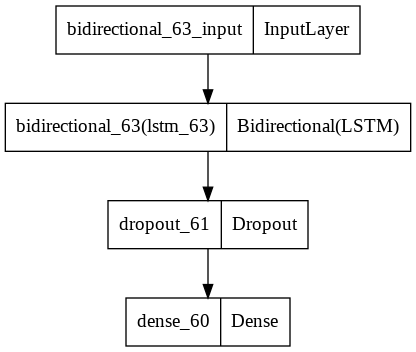

In [1181]:
# fit the model and plot it 

history = model.fit(
    train_x, train_y, 
    epochs=45, 
    batch_size=64, 
    validation_data =(test_x, test_y),
    shuffle=False
)
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

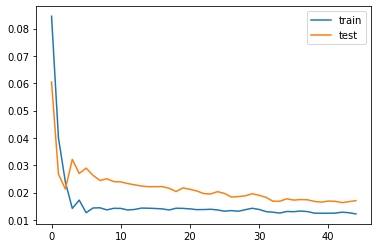

In [1182]:
# plotting mse loss against epochs 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [1185]:
# inverting the scale of predicted, train , test values 

y_pred = model.predict(test_x)
train_y_inv = scaler2.inverse_transform(train_y.reshape(1, -1))
test_y_inv = scaler2.inverse_transform(test_y.reshape(1, -1))
y_pred_inv = scaler2.inverse_transform(y_pred)

In [1186]:
# dimenstions of outputs 
print(y_pred.shape,test_y.shape,train_y.shape)

(145, 1) (145,) (583,)


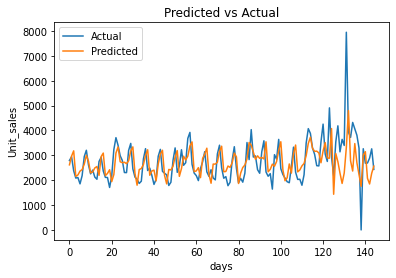

In [1187]:
# plotting actual v predicted values 

plt.plot(test_y_inv.flatten() )
plt.plot(y_pred_inv.flatten())
plt.title('Predicted vs Actual')
plt.ylabel('Unit_sales')
plt.xlabel('days')
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.show()



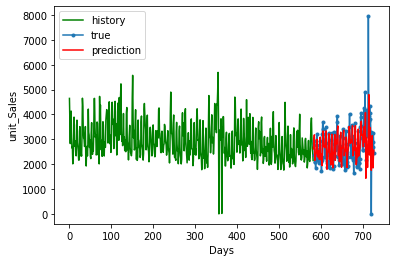

In [1188]:

# including the history and then the segmantation point, overlay both prediced and true values 

plt.plot(np.arange(0, len(train_y)), train_y_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(train_y), len(train_y) + len(test_y)), test_y_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(train_y), len(train_y) + len(test_y)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('unit_Sales')
plt.xlabel('Days')
plt.legend()
plt.show();


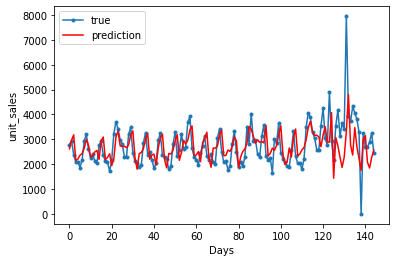

In [1189]:
# isolate predicted and true 

plt.plot(test_y_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('unit_sales')
plt.xlabel('Days')
plt.legend()
plt.show();


In [1191]:

# calculate RMSE
rmse = math.sqrt(mean_squared_error(test_y_inv.flatten(),y_pred_inv.flatten()))
print('Test RMSE: %.10f' % rmse)

Test RMSE: 742.6521462579
